In [1]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
import geojson
import geopandas as gpd
from rasterio.mask import geometry_mask

# Download data if needed

## Download Sentinel-2 data

In [3]:
!rm download*
!wget https://cloud.irit.fr/s/E22CahuMVTBhsbI/download
!unzip download
!rm download
!mv sentinel2_bands data

--2024-07-24 10:50:04--  https://cloud.irit.fr/s/E22CahuMVTBhsbI/download
Resolving cloud.irit.fr (cloud.irit.fr)... 141.115.28.28
Connecting to cloud.irit.fr (cloud.irit.fr)|141.115.28.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘download’

download                [           <=>      ]   5,54G  29,5MB/s    in 3m 28s  

2024-07-24 10:53:33 (27,2 MB/s) - ‘download’ saved [5944800348]

Archive:  download
   creating: sentinel2_bands/
   creating: sentinel2_bands/2019/
   creating: sentinel2_bands/2019/01_january/
 extracting: sentinel2_bands/2019/01_january/T31TEJ_20190103T104431_B02_10m.jp2  
 extracting: sentinel2_bands/2019/01_january/T31TEJ_20190103T104431_B03_10m.jp2  
 extracting: sentinel2_bands/2019/01_january/T31TEJ_20190103T104431_B04_10m.jp2  
 extracting: sentinel2_bands/2019/01_january/T31TEJ_20190103T104431_B08_10m.jp2  
   creating: sentinel2_bands/2019/02_february/
 extracting: sentinel2_bands/2019

## Download elevation data

In [ ]:
!rm download*
!wget https://cloud.irit.fr/s/HBeMWkfLvhkysrf/download
!unzip download
!rm download
!mv 'Elevation data' data/elevation_data

rm: cannot remove 'download*': No such file or directory
--2024-07-24 10:58:00--  https://cloud.irit.fr/s/HBeMWkfLvhkysrf/download
Resolving cloud.irit.fr (cloud.irit.fr)... 141.115.28.28
Connecting to cloud.irit.fr (cloud.irit.fr)|141.115.28.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘download’

download                [ <=>                ] 289,20M  46,2MB/s    in 6,5s    

2024-07-24 10:58:07 (44,3 MB/s) - ‘download’ saved [303251626]

Archive:  download
   creating: Elevation data/
 extracting: Elevation data/raw_elevation_data_10m.tif  


## Download geojson dataset

In [16]:
!rm download*
!wget https://cloud.irit.fr/s/3hEr67GQ2C4bWG9/download
!mv download data/dataset.geojson

--2024-07-24 11:07:46--  https://cloud.irit.fr/s/3hEr67GQ2C4bWG9/download
Resolving cloud.irit.fr (cloud.irit.fr)... 141.115.28.28
Connecting to cloud.irit.fr (cloud.irit.fr)|141.115.28.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58238343 (56M) [application/octet-stream]
Saving to: ‘download’

download            100%[===================>]  55,54M  38,6MB/s    in 1,4s    

2024-07-24 11:07:48 (38,6 MB/s) - ‘download’ saved [58238343/58238343]



# Define paths

Data tree path should look like this:
```
.  
|__data/  
    |__sentinel2_bands/<year>/<month>/<band>
    |__elevation_data/  
    |__dataset.geojson
```

In [2]:
import os

def get_elevation_data_path() -> str:
    return os.path.abspath("./data/elevation_data/raw_elevation_data_10m.tif")

def get_geojson_path() -> str:
    return os.path.abspath("./data/dataset.geojson")
    
def get_sentinel_data_path() -> dict:
    paths = {}
    years = os.listdir("data/sentinel2_bands")
    for year in years:
        y = int(year)
        paths[y] = {}
        months = os.listdir(f"data/sentinel2_bands/{year}")
        for month in months:
            m = int(month.split("_")[0])
            paths[y][m] = {}
            bands = os.listdir(f"data/sentinel2_bands/{year}/{month}/") 
            for band in bands:
                band_name = band.split("_")[2]
                paths[y][m][band_name] = os.path.abspath(f"./data/sentinel2_bands/{year}/{month}/{band}")
    return paths

sentinel_data_path = get_sentinel_data_path()
elevation_path = get_elevation_data_path()
geojson_path = get_geojson_path()

print(elevation_path)
print(geojson_path)
print(f"Data path for sentinel-2, 2019, february, red band: {sentinel_data_path[2019][2]['B03']}")

/home/melsakka/Projects/Ter-2024/data/elevation_data/raw_elevation_data_10m.tif
/home/melsakka/Projects/Ter-2024/data/dataset.geojson
Data path for sentinel-2, 2019, february, red band: /home/melsakka/Projects/Ter-2024/data/sentinel2_bands/2019/02_february/T31TEJ_20190227T104019_B03_10m.jp2


In [3]:
# Load metadata and band data
meta = rasterio.open(sentinel_data_path[2019][1]['B08']).meta

blue_band = rasterio.open(sentinel_data_path[2019][1]['B02']).read(1).astype('float32')
green_band = rasterio.open(sentinel_data_path[2019][1]['B03']).read(1).astype('float32')
red_band = rasterio.open(sentinel_data_path[2019][1]['B04']).read(1).astype('float32')
nir_band = rasterio.open(sentinel_data_path[2019][1]['B08']).read(1).astype('float32')
elevation = rasterio.open(elevation_path).read(1).astype('float32')

In [9]:
# Function to plot bands
def plot(arr, title):
    plt.imshow(arr)
    plt.axis('off')
    plt.colorbar()
    plt.title(title)
    plt.show()

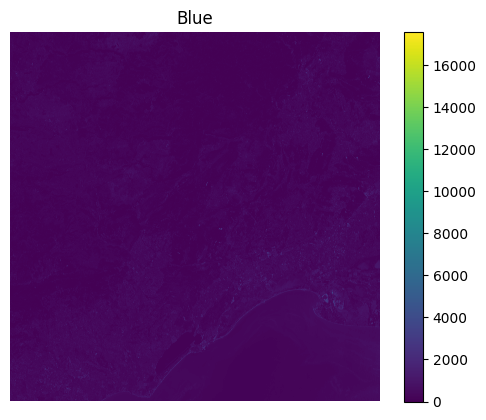

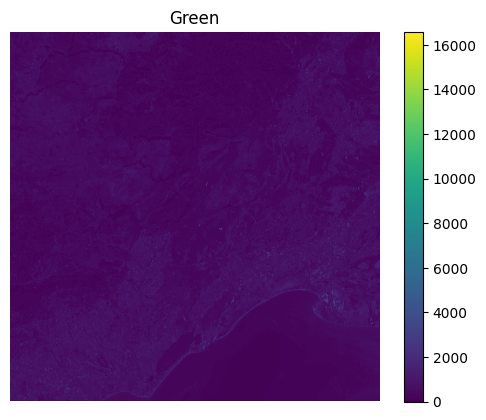

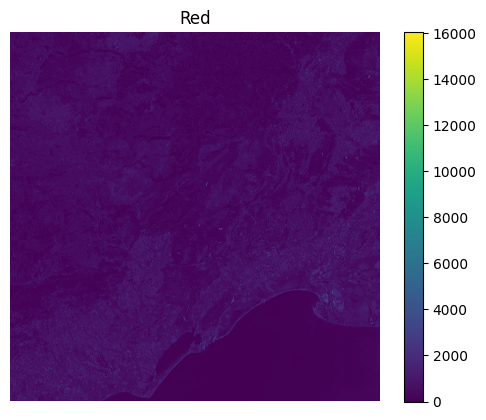

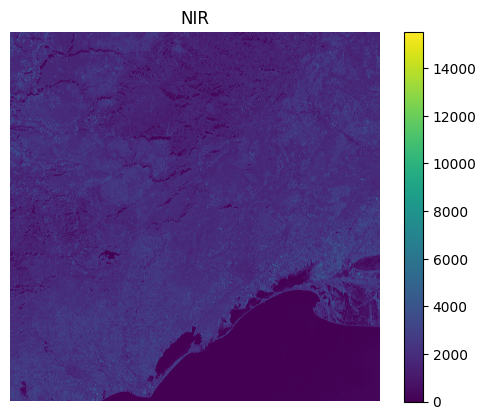

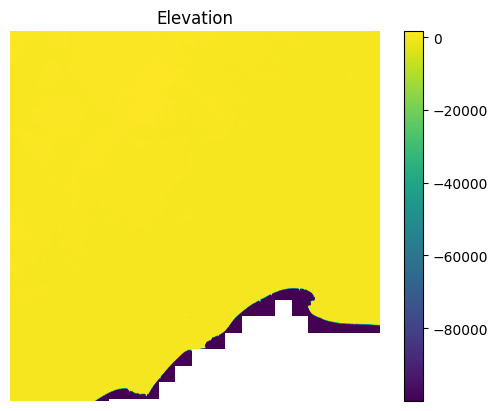

In [10]:
# Plot the bands
plot(blue_band, "Blue")
plot(green_band, "Green")
plot(red_band, "Red")
plot(nir_band, "NIR")
plot(elevation, "Elevation")

In [13]:
nir = rasterio.open(sentinel_data_path[2019][1]['B08'])

gdf = gpd.read_file(geojson_path)
gdf = gdf.to_crs(nir.crs)

In [14]:
labels = ["Limite", "Assez_limite", "Moyen", "Assez_fort", "Fort_a_tres_fort"]
band_paths = [sentinel_data_path[2019][1]['B02'], sentinel_data_path[2019][1]['B03'], sentinel_data_path[2019][1]['B04'], sentinel_data_path[2019][1]['B08']]
band_names = ["Blue", "Green", "Red", "NIR"]

# Create the combined mask
combined_mask = np.zeros(nir.shape, dtype=bool)
for label in labels:
    mask = geometry_mask(gdf[gdf["pot_global"] == label].geometry, 
                         out_shape=nir.shape, 
                         transform=nir.transform, 
                         invert=True)
    combined_mask |= mask

In [ ]:
# Resample elevation data to match the other bands
with rasterio.open(elevation_path) as src:
    elevation_meta = src.meta
    transform, width, height = calculate_default_transform(
        src.crs, meta['crs'], meta['width'], meta['height'], *src.bounds)
    elevation_resampled = np.zeros((meta['height'], meta['width']), np.float32)

    reproject(
        source=rasterio.band(src, 1),
        destination=elevation_resampled,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=meta['transform'],
        dst_crs=meta['crs'],
        resampling=Resampling.nearest)

In [ ]:
# Create mask for elevation data
elevation_mask = np.zeros(elevation_resampled.shape, dtype=bool)
for label in labels:
    mask = geometry_mask(gdf[gdf["pot_global"] == label].geometry,
                         out_shape=elevation_resampled.shape,
                         transform=meta['transform'],
                         invert=True)
    elevation_mask |= mask  

In [ ]:
# Create 3D array to hold band values
values = np.zeros((nir_band.shape[0], nir_band.shape[1], 5), dtype='float32')

# Fill values array with band data
for i, (band_path, band_name) in enumerate(zip(band_paths, band_names)):
    band = rasterio.open(band_path).read(1).astype('float32')
    values[:, :, i] = np.where(combined_mask, band, np.nan)  # Use np.nan for masked areas

# Add resampled elevation data to values array
values[:, :, 4] = np.where(elevation_mask, elevation_resampled, np.nan)  # Use np.nan for masked areas


In [ ]:
# Display the combined mask
plt.imshow(combined_mask, cmap='gray')
plt.title("Combined Mask")
plt.show()

In [ ]:
# Display the values for each band
for i, band_name in enumerate(band_names):
    plt.imshow(values[:, :, i],vmin=0, vmax=2000)
    plt.title(f"{band_name} Values")
    plt.colorbar()
    plt.show()

In [ ]:
plt.imshow(values[:, :, 4],vmin=-5, vmax=500)
plt.title(f"Elevation Values")
plt.colorbar()
plt.show() 